In [25]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import os
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r'\archive'
file_names=os.listdir(path)
txt_file_names = [file_name for file_name in file_names if file_name.endswith('.txt')]
print(txt_file_names)

['test.txt', 'train.txt', 'val.txt']


In [3]:
os.chdir(path)
df = pd.read_csv("train.txt",header=None, sep=";")
df.head(5)

,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger


In [4]:
column_names = ['description','emotion']
df.columns = column_names

In [5]:
#get the max column widths of the columns
column_widths = df.applymap(str).applymap(len).max()
print(column_widths)

description    300
emotion          8
dtype: int64


In [6]:
df['emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [8]:
text = ' '.join(df['description'].values)

In [9]:
wordcloud = WordCloud(width=800, height=400, max_font_size=150, background_color='white').generate(text)

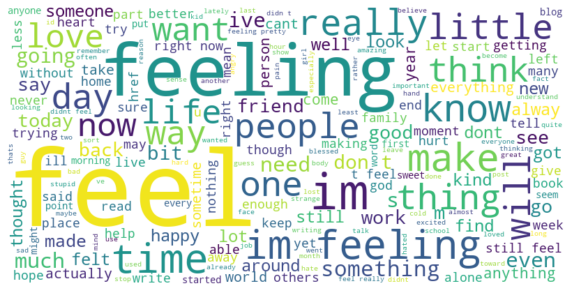

In [10]:
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)


tokens = word_tokenize(text.lower())

stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in tokens if token not in stop_words]

lemmatizer = WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

word_counts = Counter(lemmatized_tokens)
top_words = word_counts.most_common(10)
words = [word[0] for word in top_words]
frequencies = [word[1] for word in top_words]

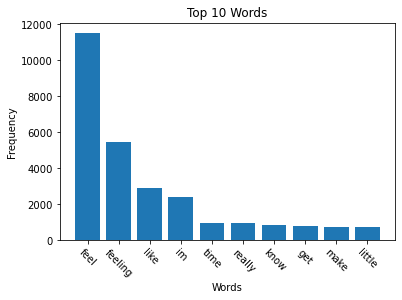

In [12]:
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words')
plt.xticks(rotation=-45)
plt.show()

<AxesSubplot:xlabel='emotion', ylabel='count'>

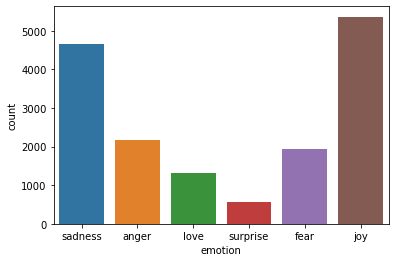

In [27]:
import seaborn as sns
sns.countplot(df['emotion'])

<AxesSubplot:xlabel='emotion', ylabel='count'>

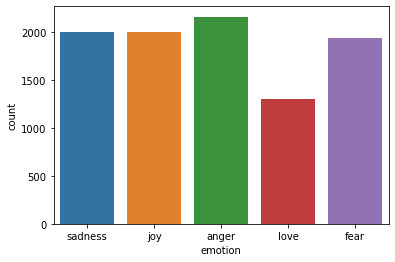

In [28]:
# Correct imbalanced database:(1) Surpirse section will be dropped (too small) (2) Sadness, job sections need to reduce size.
sadness = df[df['emotion']=='sadness'].sample(2000)
joy = df[df['emotion']=='joy'].sample(2000)
others = df[df['emotion'].isin(['anger', 'love', 'fear'])]
data = pd.concat([sadness,joy,others])
sns.countplot(data['emotion'])

In [30]:
features = data['description']
labels = data['emotion']
labels=labels.map({'joy':0, 'love':1, 'anger':2, 'fear':3,'sadness':4})

In [35]:
# TF-IDF and Naive Bayes
# TF-IDF(Term Frequency-Inverse Document Frequency): measures how important a term is within a document relative to a corpus.
# Naive Bayes: powerful algorithm used for text data analysis and with problems with multiple classes
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Train/Test splitting (80/20)
X_train,X_test,Y_train,Y_test=train_test_split(features,labels,test_size=0.2,random_state=1000)

# Build Multinominal Naive Bayes Model
multinomial_nb = Pipeline([('vectorizer', TfidfVectorizer()), ('model', MultinomialNB())])

# Training the model
multinomial_nb.fit(X_train, Y_train)

# Evaluating the model
from sklearn.metrics import classification_report;
from sklearn.metrics import confusion_matrix
y_pred_multinomial_nb = multinomial_nb.predict(X_test)

# Getting the classification report
cr_multinomial_nb = classification_report(Y_test, y_pred_multinomial_nb)

print(cr_multinomial_nb)

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       393
           1       0.93      0.25      0.39       270
           2       0.70      0.91      0.79       436
           3       0.88      0.82      0.85       401
           4       0.78      0.82      0.80       380

    accuracy                           0.77      1880
   macro avg       0.80      0.73      0.72      1880
weighted avg       0.79      0.77      0.75      1880



<AxesSubplot:>

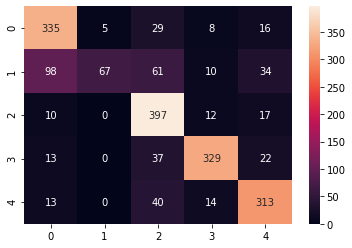

In [36]:
# heatmap of Multinomial Naive Bayes
cm_multinomial_nb = confusion_matrix(Y_test, y_pred_multinomial_nb)
sns.heatmap(cm_multinomial_nb, annot = True, fmt = 'd')

In [39]:
# Rondom Forest Classifier: combines the output of multiple decision trees to reach a single result
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

params={'criterion':['gini','entropy'], 'n_estimators':[25,5,100,40,50]}

clf=RandomizedSearchCV(RandomForestClassifier(),params)
vectorizer=TfidfVectorizer()
x_train=vectorizer.fit_transform(X_train)
clf.fit(x_train,Y_train)

clf.best_params_

random_forest=Pipeline([('vectorizer',TfidfVectorizer()),('model',RandomForestClassifier(n_estimators=100,criterion='gini'))])

random_forest.fit(X_train,Y_train)

In [40]:
# Evaluating the model
y_pred_random_forest = random_forest.predict(X_test)
cr_random_forest = classification_report(Y_test, y_pred_random_forest)
print(cr_random_forest)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       393
           1       0.83      0.93      0.88       270
           2       0.89      0.86      0.87       436
           3       0.92      0.88      0.90       401
           4       0.83      0.83      0.83       380

    accuracy                           0.86      1880
   macro avg       0.86      0.86      0.86      1880
weighted avg       0.86      0.86      0.86      1880



<AxesSubplot:>

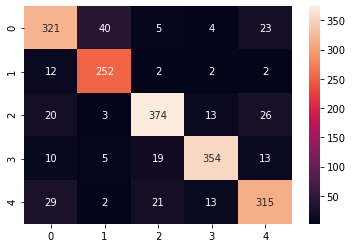

In [41]:
# heatmap of Random Forest Classifier
cm_random_forest = confusion_matrix(Y_test, y_pred_random_forest)
sns.heatmap(cm_random_forest, annot = True, fmt = 'd')

In [44]:
# Support Vector Machines (SVM): a set of supervised learning methods used for classification, regression, outliers detection.
# hyperparameter tuning
from sklearn.svm import SVC

params = {'C': [1, 1.2, 1.5], 'kernel':['linear', 'poly', 'rbf'], 'degree':[3, 5, 4, 10]}

# Hyperparameter runing
clf = RandomizedSearchCV(SVC(), params)
clf.fit(x_train, Y_train)

clf.best_params_

{'kernel': 'linear', 'degree': 3, 'C': 1.2}

In [45]:
svm = Pipeline([('vectorizer', TfidfVectorizer()), ('model', SVC(kernel='linear', C=1))])
svm.fit(X_train, Y_train)

y_pred_svm = svm.predict(X_test)
cr_svm = classification_report(Y_test, y_pred_svm)
print(cr_svm)

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       393
           1       0.82      0.90      0.86       270
           2       0.90      0.89      0.90       436
           3       0.92      0.88      0.90       401
           4       0.89      0.89      0.89       380

    accuracy                           0.88      1880
   macro avg       0.88      0.88      0.88      1880
weighted avg       0.88      0.88      0.88      1880



<AxesSubplot:>

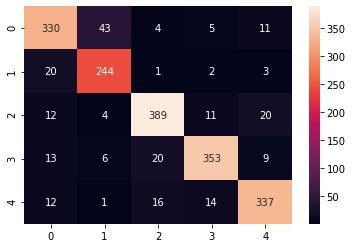

In [46]:
cm_svm = confusion_matrix(Y_test, y_pred_svm)
sns.heatmap(cm_svm, annot = True, fmt = "d")